<a href="https://colab.research.google.com/github/bin43256/Deep-Learning-Specialization/blob/main/Undergrad_research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview
This notebook builds on a sequence and time series model using both convolutional neural network(CNN) and long short-term-memory(LSTM) layers to predict `particulate matters(i.e.,pollutants)` in construction site, by implementing few python packages to help with processing, visualizing the data, as well as training, and testing the model.

In [11]:
!nvidia-smi

Fri Nov 10 01:13:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading data
The dataset comes from different dates, and the first thing to do is to join all the datasets into single compiled dataset using `os` and `pandas`.


In [13]:
import os
import pandas as pd

#Find all the folders that contains the cleaned csv file and concatenate into a single dataframe
construction_df = pd.DataFrame()
for root, dirs, files in os.walk(r"/content/drive/MyDrive/UR"):
    for file in files:
        if file == 'new_dataset_cleaned.csv':
           full_path = (os.path.join(root,file))
           df = pd.read_csv(full_path)
           construction_df = pd.concat([construction_df, df], ignore_index=True)

#Exploratory Data Analysis

##Line Graph
Here, we are plotting the Environmental features and three source of PMs for the first day using a package `plotly`.

In [15]:
construction_df.head()

,Time,Temperature,Pressure,Humidity,Light,Oxidising,Reducing,NH3,PM1,PM2.5,PM10,Truck,Lifter,Human
0,2023-06-26 15:51:34,26.558377,935.358343,40.051227,303.40830,2.388626,215.365639,91.016706,6,9,9,6,5,0
1,2023-06-26 15:51:37,26.449188,935.377201,39.983872,306.15605,2.444023,217.777778,94.980392,6,8,8,1,4,0
2,2023-06-26 15:51:40,26.552396,935.345131,39.950192,312.51865,2.444023,219.000000,97.233831,6,8,8,0,2,0
3,2023-06-26 15:51:43,26.725583,935.348188,39.989490,316.98160,2.499525,217.777778,98.000000,6,8,8,0,3,0
4,2023-06-26 15:51:46,26.530623,935.363473,39.978262,72.55190,2.555133,220.233184,101.544757,6,7,7,1,2,0


In [16]:
construction_df.columns

Index(['Time', 'Temperature', 'Pressure', 'Humidity', 'Light', 'Oxidising',
       'Reducing', 'NH3', 'PM1', 'PM2.5', 'PM10', 'Truck', 'Lifter', 'Human'],
      dtype='object')

In [17]:
import plotly.express as px

plot_length = 300
plot_df = construction_df.copy(deep=True).iloc[:plot_length]

fig1 = px.line(plot_df,
              x="Time",
              y=["PM1", "PM2.5", "PM10"],
              color_discrete_map={"PM1": "red", "PM2.5":'green', "PM10": "yellow","Temperature":"blue"},
              title="7/26/2023 PM vs Time")

fig2 = px.line(plot_df,
              x="Time",
              y=['Temperature','Humidity','Oxidising'],
              color_discrete_map={"Temperature": "red", "Humidity":'green',"Oxidising":"blue"},
              title="7/26/2023 Environmental Features 1")
fig3 = px.line(plot_df,
              x="Time",
              y=['Light','Reducing','NH3'],
              color_discrete_map={ "Light": "yellow","Oxidising":"blue",'Reducing':'cyan'},
              title="7/26/2023 Environmental Features 2")

fig1.show()
fig2.show()
fig3.show()

##Heat Map
We can visualize the degree of correlation between each variable to tell if they are positive, negative, or neutral to one another in a grid with different intensity of color.

<ipython-input-18-7bcb837c9099>:4: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



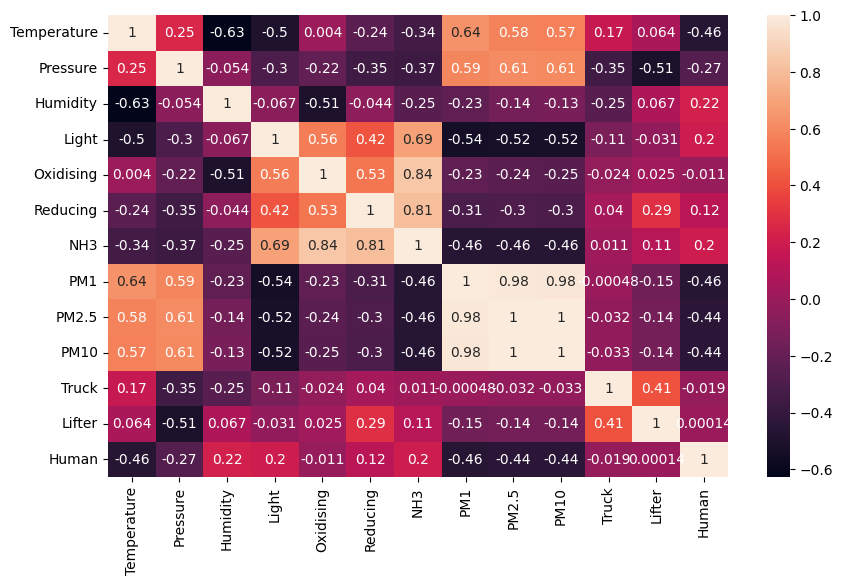

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.heatmap(construction_df.corr(),annot=True)
plt.show()

# Preparing data

###*Distinguish Input/Output Variables*






In [21]:
Input_variables = ['Temperature','Light','Pressure', 'Humidity','Oxidising',
        'Reducing', 'NH3','Truck', 'Human', 'Lifter']
input_array = construction_df[Input_variables].values
output_variables = ['PM1','PM2.5','PM10']
output_array = construction_df[output_variables].values
print(input_array[0])


[ 26.55837733 303.4083     935.3583428   40.05122715   2.38862559
 215.3656388   91.01670644   6.           0.           5.        ]


###*Normalizing/Scaling Data*

Why is Normalization important:
*   Prevent model from learning and biasing toward certain variables
*   Facilitate Faster training time and decrease the need for more computational power

Note: It's best practice to fit only the scaler to **training** data because we don't want to refer to the "future" information and prevent data leakage.



In [22]:
train_split = 0.8
n_train = int(train_split * len(construction_df))
n_test = len(construction_df) - n_train

from sklearn.preprocessing import MinMaxScaler
input_scaler = MinMaxScaler()
input_scaler.fit(input_array[:n_train]) # we are computing the min and max on the training data

scaled_input_array = pd.DataFrame(input_scaler.transform(input_array),columns =Input_variables) # we are applying the min-max normalization on all data
output_scaler = MinMaxScaler()
output_scaler.fit(output_array[:n_train]) # we are computing the min and max on the training data
scaled_output_array = pd.DataFrame(output_scaler.transform(output_array), columns=output_variables) # we are applying the min-max normalization on all data
print(scaled_input_array)

       Temperature     Light  Pressure  Humidity  Oxidising  Reducing  \
0         0.595860  0.036558  0.943769  0.357078   0.022673  0.643595   
1         0.589449  0.036890  0.943855  0.355591   0.023427  0.651160   
2         0.595509  0.037659  0.943708  0.354847   0.023427  0.654994   
3         0.605678  0.038199  0.943722  0.355715   0.024182  0.651160   
4         0.594231  0.008650  0.943792  0.355467   0.024938  0.658861   
...            ...       ...       ...       ...        ...       ...   
11241     0.417512  0.152199  1.008692  0.693604   0.168872  0.748931   
11242     0.432116  0.151395  1.008827  0.698899   0.167818  0.748931   
11243     0.429733  0.151221  1.008706  0.693621   0.167818  0.748931   
11244     0.433828  0.150913  1.008714  0.686556   0.166766  0.748931   
11245     0.431241  0.150565  1.008681  0.664027   0.166766  0.748931   

            NH3  Truck  Human    Lifter  
0      0.191939  0.750    0.0  0.454545  
1      0.200379  0.125    0.0  0.363636

###*Creating input time series using **sliding window**.*

Since the time between each row is in unit of seconds, a smaller window would be less effective for model observe the change, so We set the windows `input_length` of **60 timesteps** (equivalent to 3 minutes) to output the prediction.

In [23]:
import numpy as np
input_length = 60
output_length = 1

def create_sliding_window(input_array, output_array, input_length, output_length, stride=1):
    X_list, y_list = [], []
    for i in range(len(input_array)):
      if (i+input_length+output_length) < len(input_array):
        X_list.append(input_array.iloc[i:i+input_length:stride, :])
        y_list.append(output_array.iloc[i+input_length:i+input_length+output_length:stride, :])
    return np.array(X_list), np.array(y_list)

X, y = create_sliding_window(scaled_input_array, scaled_output_array, input_length, output_length)

###*Spliting entire data into training and testing data*

In [24]:
X_train = X[:n_train]
y_train = y[:n_train]
X_test = X[n_train:]
y_test = y[n_train:]
print('Training set examples:',len(X_train))
print('Test set examples:',len(y_test))
print(f'Sliding window size: {X_train.shape[2]}')

Training set examples: 8996
Test set examples: 2189
sliding window size: 10


# Building model

The model architecture is as follows:


* A 1D CNN with filter size of 3 & output channels of 6
* A uni-directional LSTM with 2 layers & hidden states of size 128
* A uni-directional LSTM with 2 layers & hidden states of size 32
* Dropout & Relu is applied after each layer.
* A fully connected layer for computing the final predicted values

In [25]:
import torch
import torch.nn as nn

class LSTM(nn.Module):

    def __init__(self, num_input_variable,num_input_channel, num_output_variable, output_length):
        super().__init__()
        self.num_layer = 2
        self.hidden_state_size1 = 128
        self.hidden_state_size2 = 32
        self.kernel_size = 3
        self.num_output_channel = 6
        self.CNN = nn.Conv1d(num_input_channel,self.num_output_channel,self.kernel_size,padding='same')
        self.lstm1 = nn.LSTM(num_input_variable, self.hidden_state_size1, self.num_layer, batch_first=True)
        self.lstm2 = nn.LSTM(self.hidden_state_size1, self.hidden_state_size2, self.num_layer, batch_first=True)
        self.dropout = nn.Dropout(p=0.25)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(self.hidden_state_size2, num_output_variable*output_length)

    def forward(self, x):
        input_length = x.shape[0]
        output = self.CNN(x)
        output = self.relu(output)
        output = self.dropout(output)
        h0 = torch.zeros(self.num_layer, input_length, self.hidden_state_size1)
        c0 = torch.zeros(self.num_layer, input_length, self.hidden_state_size1)
        output, _ = self.lstm1(output, (h0,c0))
        output = self.dropout(output)
        h0 = torch.zeros(self.num_layer, input_length, self.hidden_state_size2)
        c0 = torch.zeros(self.num_layer, input_length, self.hidden_state_size2)
        output, _ = self.lstm2(output, (h0,c0))
        output = self.dropout(output)
        output = self.relu(output)
        output = output[:, -1, :]
        y_pred = self.fc(output)
        return y_pred

# Training model

 We use a gradient decent algorithm `adam` and mean squared error (MSE) as the loss function for multiple variable regression problem, while experimenting with the choice of hyperparameters in order to train a better model, we set the batch size to 128, epochs to 8, and learning rate to 0.001.

In [26]:
batch_size = 128
n_epochs = 8
learning_rate = 0.001

lstm_model = LSTM(num_input_variable=len(Input_variables), num_input_channel = X_train.shape[1],num_output_variable=len(output_variables), output_length=output_length)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)

In [27]:
lstm_model.train()
for e in range(n_epochs):
    for b in range(0, len(X_train), batch_size): #torch.randint(1, batch_size, (1,))
        if b+batch_size >= len(X_train):
            continue
        X_batch = torch.tensor(X_train[b:b+batch_size], dtype=torch.float32)
        y_batch = torch.tensor(y_train[b:b+batch_size], dtype=torch.float32)
        y_pred = lstm_model(X_batch)
        loss = criterion(y_pred.view(-1), y_batch.view(-1))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f'Epoch {e+1} loss:{loss.item()}')

Epoch 1 loss:0.272636353969574
Epoch 2 loss:0.28273311257362366
Epoch 3 loss:0.23981380462646484
Epoch 4 loss:0.22280843555927277
Epoch 5 loss:0.23596042394638062
Epoch 6 loss:0.24144138395786285
Epoch 7 loss:0.21272797882556915
Epoch 8 loss:0.2278061956167221


# Evaluating/testing model

We now finish training the model. We can apply the trained model on the testing data.



In [28]:
y_pred_scaled = lstm_model(torch.tensor(X_test, dtype=torch.float32)).detach().numpy().squeeze()
y_pred = output_scaler.inverse_transform(y_pred_scaled)
y_truth = construction_df[output_variables].iloc[n_train+input_length+1::1]
print(y_pred, y_truth)


[[12.539526 17.289124 18.70913 ]
 [ 9.725127 10.162472 15.014184]
 [12.237858 22.244274 18.240736]
 ...
 [14.350522 17.681395 17.849836]
 [11.849683 20.143826 19.565973]
 [13.308778 22.061377 21.677933]]        PM1  PM2.5  PM10
9057     5      7     7
9058     5      7     7
9059     5      7     7
9060     5      7     7
9061     5      7     7
...    ...    ...   ...
11241   16     24    27
11242   18     27    29
11243   19     28    30
11244   20     28    30
11245   20     28    29

[2189 rows x 3 columns]


We can use MSE as the evaluation metric.

In [29]:
from sklearn.metrics import mean_squared_error
y_pred[:,0]
y_truth_array = y_truth.values
y_truth_array[:,0]

print(f'Mean Square Error: {mean_squared_error(y_truth, y_pred)}')



Mean Square Error: 106.28944669505806


Let's plot the predicted and actual values to the Line graph and have a look at the comparison between these values

In [31]:
testing_df = pd.DataFrame()
testing_df['Time'] = construction_df['Time'].iloc[n_train+input_length+1::1]
testing_df['PM1'] = y_pred[:,0]
testing_df['PM2.5'] = y_pred[:,1]
testing_df['PM10'] = y_pred[:,2]
testing_df.head()
testing_df['source'] = 'Test Prediction'


testing_truth_df = pd.DataFrame()
testing_truth_df['Time'] = testing_df['Time']
testing_truth_df['PM1'] = y_truth['PM1']
testing_truth_df['PM2.5'] = y_truth['PM2.5']
testing_truth_df['PM10'] = y_truth['PM10']

testing_truth_df['source'] = 'True Values'

evaluation = pd.concat([testing_df, testing_truth_df], axis = 0, ignore_index = True)
evaluation
evaluation['Time']  = pd.to_datetime(evaluation['Time'], format='%Y-%m-%d %H:%M:%S')
evaluation['Time'] = evaluation['Time'].dt.strftime('%m-%d %H:%M:%S')

fig1 = px.line(evaluation,
                 x="Time",
                 y='PM1',
                 color="source",
                 title="Energy Consumption vs Time")
fig1.update_xaxes(showticklabels=False)

fig2 = px.line(evaluation,
                 x="Time",
                 y='PM2.5',
                 color="source",
                 title="PM2.5 vs Time")
fig2.update_xaxes(showticklabels=False)
fig3 = px.line(evaluation,
                 x="Time",
                 y='PM10',
                 color="source",
                 title="PM10 vs Time")
fig3.update_xaxes(showticklabels=False)
fig1.show()
fig2.show()
fig3.show()

#Implications and Thoughts
Presumably, we want the predicted values to align with or close to the real values, in this case, the predicted values fluctuate horizontally and thus only computing the average, fail to learn the trend and the pattern of the real values. We attempt to address the performance by experimenting with different sets of hyperparameters, but the improvement is subtle.  
As for now, we are deducing that the issue lies in the data itself, the deployed sensors may produce error during the data collection process and recorded the false environmental data and PM values.
